## Import Libraries

In [552]:
import pandas as pd
import re
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality, degree_centrality, eigenvector_centrality, closeness_centrality

# Ensure all packages are installed
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import networkx as nx
except ImportError as e:
    print(f'Missing package: {e.name}')
    !pip install {e.name}

## Read Transcription Files

In [553]:
# Read all transcription files
def read_transcriptions(folder_path):
    files = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    transcriptions = []
    for file in files:
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            transcriptions.append(f.read())
    return transcriptions

project3_path = 'transcriptions/project3'
project4_path = 'transcriptions/project4'
transcriptions_project3 = read_transcriptions(project3_path)
transcriptions_project4 = read_transcriptions(project4_path)

## Extract Speaker Turns

In [554]:
# Extract speaker turns
def extract_speaker_turns(data):
    speaker_pattern = re.compile(r'Speaker (SPEAKER_\d+):')
    turns = speaker_pattern.split(data)[1:]  # Split and remove the first empty element
    speakers = turns[0::2]
    texts = turns[1::2]
    df = pd.DataFrame({'Speaker': speakers, 'Text': texts})
    df = df[df['Text'].str.strip() != '']  # Remove rows with empty Text
    return df

dfs_project3 = [extract_speaker_turns(data) for data in transcriptions_project3]
dfs_project4 = [extract_speaker_turns(data) for data in transcriptions_project4]

## Create Combined Dataset

In [555]:
# Create a combined dataset
def create_dataset(dfs, project_number):
    dataset = []
    for i, df in enumerate(dfs):
        df['meeting_number'] = i + 1  # Add meeting number
        speaker_frequency = df['Speaker'].value_counts().to_dict()
        total_speeches = df.shape[0]
        for speaker, frequency in speaker_frequency.items():
            dataset.append({
                'id': f'{project_number}_{i}_{speaker}',
                'project': project_number,
                'meeting_number': i + 1,
                'speaker_number': int(speaker.split('_')[1]),
                'speech_frequency': frequency,
                'total_speeches': total_speeches
            })
    return pd.DataFrame(dataset)

dataset_project3 = create_dataset(dfs_project3, 3)
dataset_project4 = create_dataset(dfs_project4, 4)
dataset = pd.concat([dataset_project3, dataset_project4], ignore_index=True)

## Normalize Speech Frequency

In [556]:
# Normalize speech frequency to a maximum of 1 within each meeting
dataset['normalized_speech_frequency'] = dataset['speech_frequency'] / dataset['total_speeches']

## Compute Interaction Frequency

In [557]:
# Compute Interaction Frequency
def compute_interaction_frequency(df, project_number):
    interaction_counts = defaultdict(lambda: defaultdict(int))
    interaction_records = []
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            interaction_counts[prev_speaker][next_speaker] += 1
    for prev_speaker, next_speakers in interaction_counts.items():
        for next_speaker, count in next_speakers.items():
            interaction_records.append({
                'project': project_number,
                'meeting_number': df['meeting_number'].iloc[0],
                'speaker_id': int(prev_speaker.split('_')[1]),
                'next_speaker_id': int(next_speaker.split('_')[1]),
                'count': count
            })
    return pd.DataFrame(interaction_records)

interaction_records_project3 = pd.concat([compute_interaction_frequency(df, 3) for df in dfs_project3], ignore_index=True)
interaction_records_project4 = pd.concat([compute_interaction_frequency(df, 4) for df in dfs_project4], ignore_index=True)
interaction_records = pd.concat([interaction_records_project3, interaction_records_project4], ignore_index=True)

## Merge Datasets

In [558]:
# Merge datasets
combined_dataset = pd.merge(dataset, interaction_records, how='left', left_on=['project', 'meeting_number', 'speaker_number'], right_on=['project', 'meeting_number', 'speaker_id'])
combined_dataset['count'] = combined_dataset['count'].fillna(0).astype(int)

## Ensure Sum of Counts for Each Speaker Equals Speech Frequency

In [559]:
# Ensure sum of counts for each speaker equals speech_frequency
speaker_interaction_sum = combined_dataset.groupby(['project', 'meeting_number', 'speaker_number'])['count'].sum()
speech_frequency_series = combined_dataset.set_index(['project', 'meeting_number', 'speaker_number'])['speech_frequency']

# Align the indices of both series before comparison
speaker_interaction_sum, speech_frequency_series = speaker_interaction_sum.align(speech_frequency_series)

# Debugging: Display mismatches
mismatches = speaker_interaction_sum != speech_frequency_series
if mismatches.any():
    print('Mismatches found:')
    print(speaker_interaction_sum[mismatches])
    print(speech_frequency_series[mismatches])

assert (speaker_interaction_sum == speech_frequency_series).all(), 'Interaction counts do not match speech frequencies'

## Save Combined Dataset to CSV

In [560]:
# Save the final dataset to a CSV file
combined_dataset.to_csv('transcriptions/combined_dataset.csv', index=False)

## Plot Interaction Heatmap for Project 3

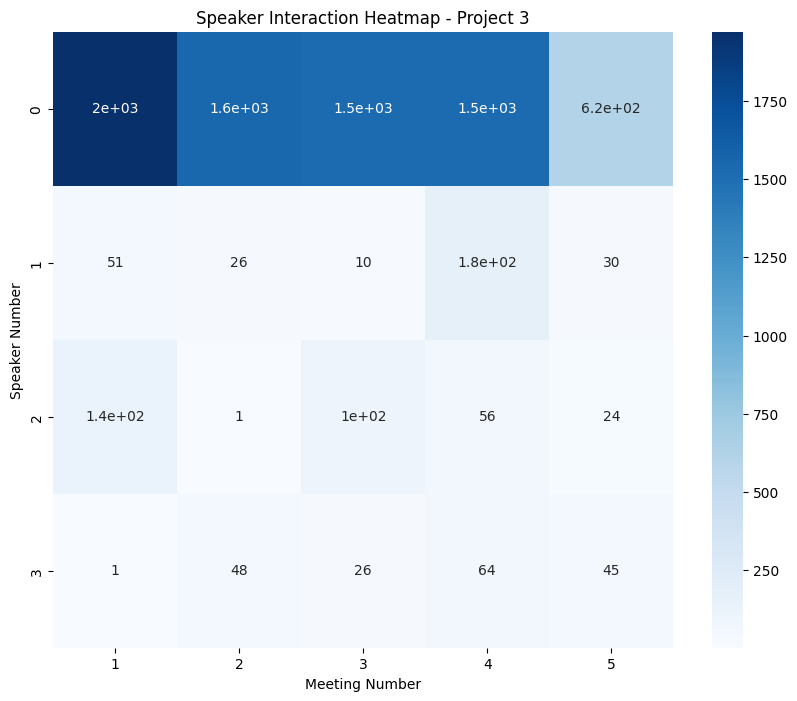

In [561]:
# Plotting Interaction Heatmap for Project 3
plt.figure(figsize=(10, 8))
sns.heatmap(combined_dataset[combined_dataset['project'] == 3].pivot_table(index='speaker_number', columns='meeting_number', values='speech_frequency', aggfunc='sum').fillna(0), annot=True, cmap='Blues')
plt.title('Speaker Interaction Heatmap - Project 3')
plt.xlabel('Meeting Number')
plt.ylabel('Speaker Number')
plt.show()

## Plot Interaction Heatmap for Project 4

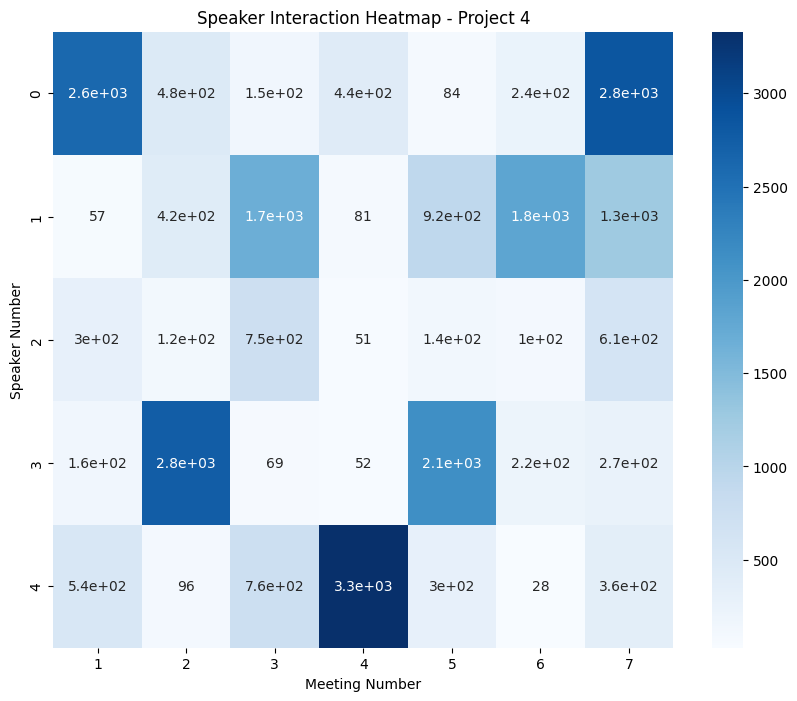

In [562]:
# Plotting Interaction Heatmap for Project 4
plt.figure(figsize=(10, 8))
sns.heatmap(combined_dataset[combined_dataset['project'] == 4].pivot_table(index='speaker_number', columns='meeting_number', values='speech_frequency', aggfunc='sum').fillna(0), annot=True, cmap='Blues')
plt.title('Speaker Interaction Heatmap - Project 4')
plt.xlabel('Meeting Number')
plt.ylabel('Speaker Number')
plt.show()

## Compute and Add Centrality Measures and Density to Dataset

In [563]:
# Compute Centrality Measures and Density
def compute_centralities_and_density(df, project_number):
    G = nx.DiGraph()
    for i in range(len(df)):
        prev_speaker = df.iloc[i]['Speaker']
        if i < len(df) - 1:
            next_speaker = df.iloc[i+1]['Speaker']
        else:
            next_speaker = df.iloc[i]['Speaker']  # Self-interaction if last speaker
        if df.iloc[i]['Text'].strip() != '':
            if G.has_edge(prev_speaker, next_speaker):
                G[prev_speaker][next_speaker]['weight'] += 1
            else:
                G.add_edge(prev_speaker, next_speaker, weight=1)
    centralities = {
        'degree_centrality': degree_centrality(G),
        'betweenness_centrality': betweenness_centrality(G),
        'closeness_centrality': closeness_centrality(G),
        'eigenvector_centrality': eigenvector_centrality(G)
    }
    density = nx.density(G)
    return centralities, density

centralities_project3 = []
densities_project3 = []
for df in dfs_project3:
    centralities, density = compute_centralities_and_density(df, 3)
    centralities_project3.append(centralities)
    densities_project3.append(density)

centralities_project4 = []
densities_project4 = []
for df in dfs_project4:
    centralities, density = compute_centralities_and_density(df, 4)
    centralities_project4.append(centralities)
    densities_project4.append(density)

## Add Centralities and Density to Combined Dataset

In [564]:
# Add Centralities and Density to Combined Dataset
for centrality_measure in ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']:
    combined_dataset[centrality_measure] = 0
combined_dataset['density'] = 0

for i, df in enumerate(dfs_project3):
    centralities = centralities_project3[i]
    density = densities_project3[i]
    for centrality_measure, centrality_values in centralities.items():
        for node, value in centrality_values.items():
            combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure] = value
    combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1), 'density'] = density

for i, df in enumerate(dfs_project4):
    centralities = centralities_project4[i]
    density = densities_project4[i]
    for centrality_measure, centrality_values in centralities.items():
        for node, value in centrality_values.items():
            combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure] = value
    combined_dataset.loc[(combined_dataset['project'] == 4) & (combined_dataset['meeting_number'] == i + 1), 'density'] = density

C:\Users\sunti\AppData\Local\Temp\ipykernel_45240\2957604674.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.6666666666666665' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure] = value
C:\Users\sunti\AppData\Local\Temp\ipykernel_45240\2957604674.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6666666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_dataset.loc[(combined_dataset['project'] == 3) & (combined_dataset['meeting_number'] == i + 1) & (combined_dataset['speaker_number'] == int(node.split('_')[1])), centrality_measure

## Save Updated Combined Dataset to CSV

In [565]:
# Save the final dataset with centralities and density to a CSV file
combined_dataset.to_csv('transcriptions/updated_combined_dataset.csv', index=False)

## Plot Comparison of Interaction Frequencies

In [566]:
# Ensure both measures lists are of the same length
max_length = max(len(interaction_frequencies_project3), len(interaction_frequencies_project4))
interaction_frequencies_project3 += [0] * (max_length - len(interaction_frequencies_project3))
interaction_frequencies_project4 += [0] * (max_length - len(interaction_frequencies_project4))

# Compare interaction frequencies by nth meeting
comparison_df = pd.DataFrame({
    'Meeting': range(1, max_length + 1),
    'Interaction_Project3': interaction_frequencies_project3,
    'Interaction_Project4': interaction_frequencies_project4
})

comparison_df

,Meeting,Interaction_Project3,Interaction_Project4
0,1,556,744
1,2,419,777
2,3,435,689
3,4,469,811
4,5,187,727
5,6,0,505


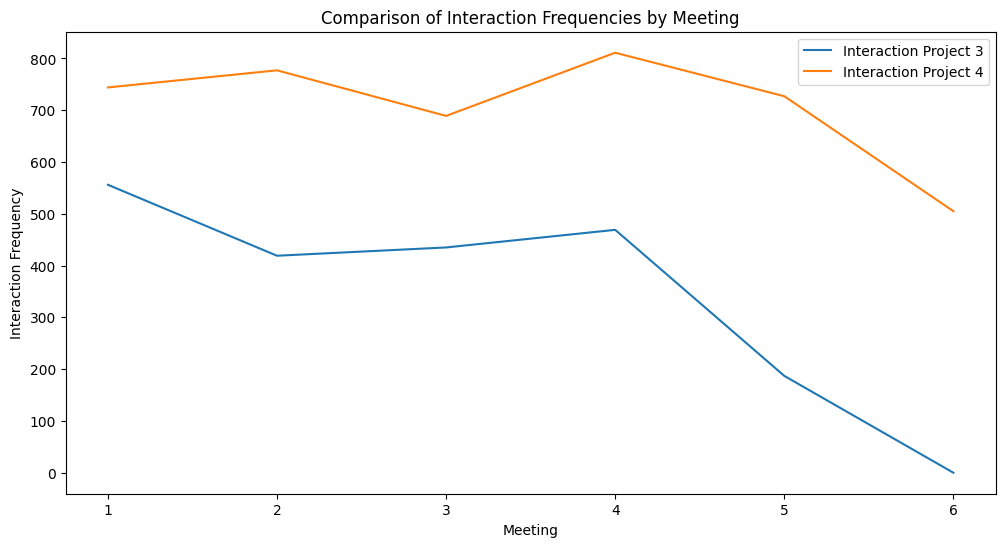

In [567]:
# Plot comparison of interaction frequencies
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project3', label='Interaction Project 3')
sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project4', label='Interaction Project 4')
plt.title('Comparison of Interaction Frequencies by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Interaction Frequency')
plt.legend()
plt.show()

## Plot Comparison of Normalized Interaction Frequencies

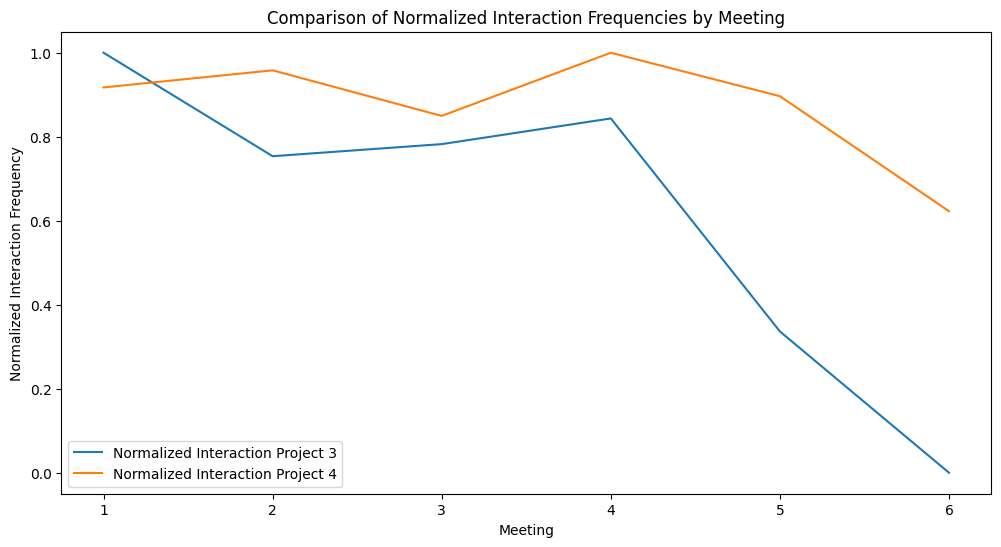

In [568]:
# Normalize interaction frequencies
comparison_df['Normalized_Interaction_Project3'] = comparison_df['Interaction_Project3'] / comparison_df['Interaction_Project3'].max()
comparison_df['Normalized_Interaction_Project4'] = comparison_df['Interaction_Project4'] / comparison_df['Interaction_Project4'].max()

# Plot comparison of normalized interaction frequencies
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project3', label='Normalized Interaction Project 3')
sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project4', label='Normalized Interaction Project 4')
plt.title('Comparison of Normalized Interaction Frequencies by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Normalized Interaction Frequency')
plt.legend()
plt.show()

## Plot Comparison of Non-Normalized Speech Frequencies

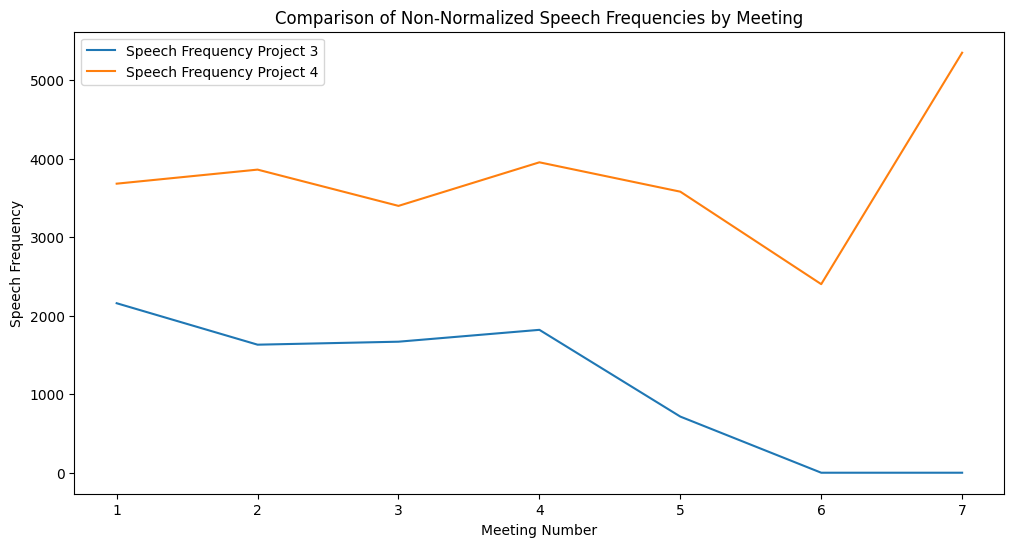

In [569]:
# Compare non-normalized speech frequencies by project
speech_comparison_df = combined_dataset.groupby(['project', 'meeting_number'])['speech_frequency'].sum().reset_index()
speech_comparison_df_pivot = speech_comparison_df.pivot(index='meeting_number', columns='project', values='speech_frequency').fillna(0)
speech_comparison_df_pivot.columns = ['Speech_Frequency_Project3', 'Speech_Frequency_Project4']
speech_comparison_df_pivot.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number', y='Speech_Frequency_Project3', label='Speech Frequency Project 3')
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number', y='Speech_Frequency_Project4', label='Speech Frequency Project 4')
plt.title('Comparison of Non-Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Speech Frequency')
plt.legend()
plt.show()

## Plot Normalized Speech Frequencies for Project 3 and Project 4

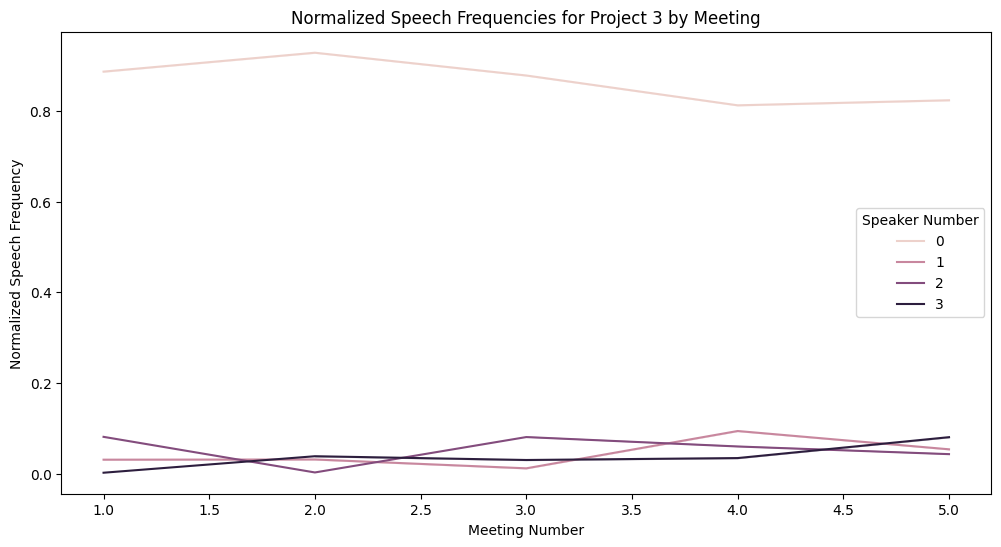

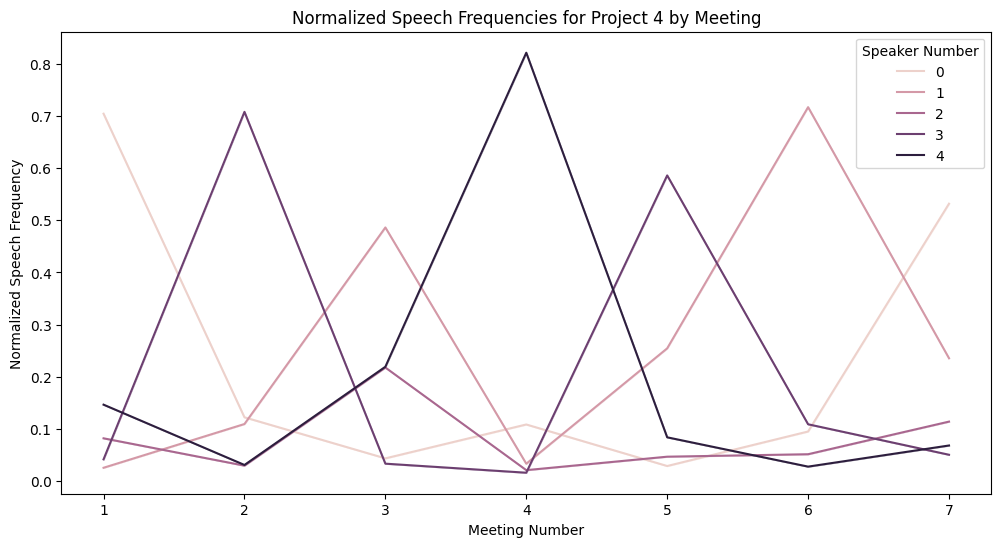

In [570]:
# Plot normalized speech frequencies for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_dataset[combined_dataset['project'] == 3], x='meeting_number', y='normalized_speech_frequency', hue='speaker_number')
plt.title('Normalized Speech Frequencies for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

# Plot normalized speech frequencies for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_dataset[combined_dataset['project'] == 4], x='meeting_number', y='normalized_speech_frequency', hue='speaker_number')
plt.title('Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

## Compare Centralities and Densities

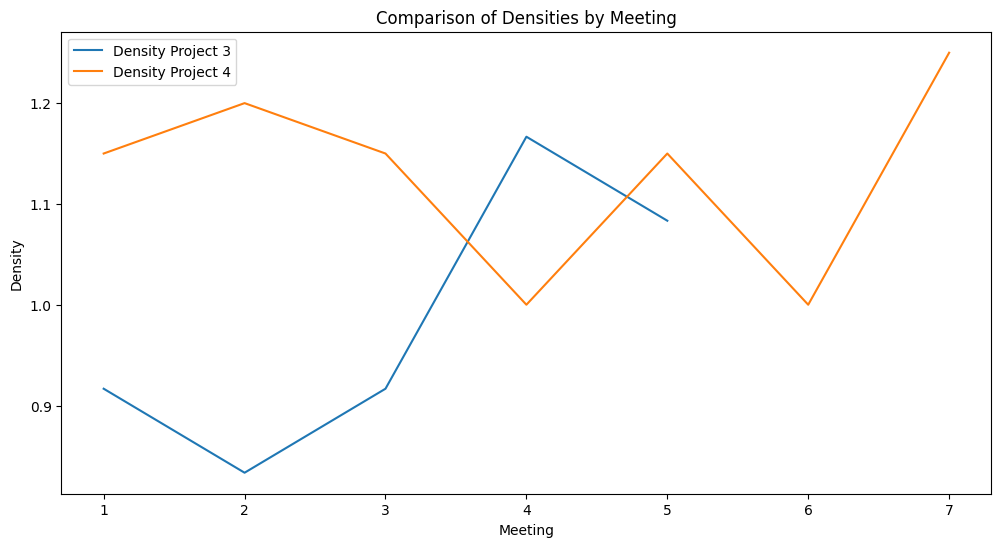

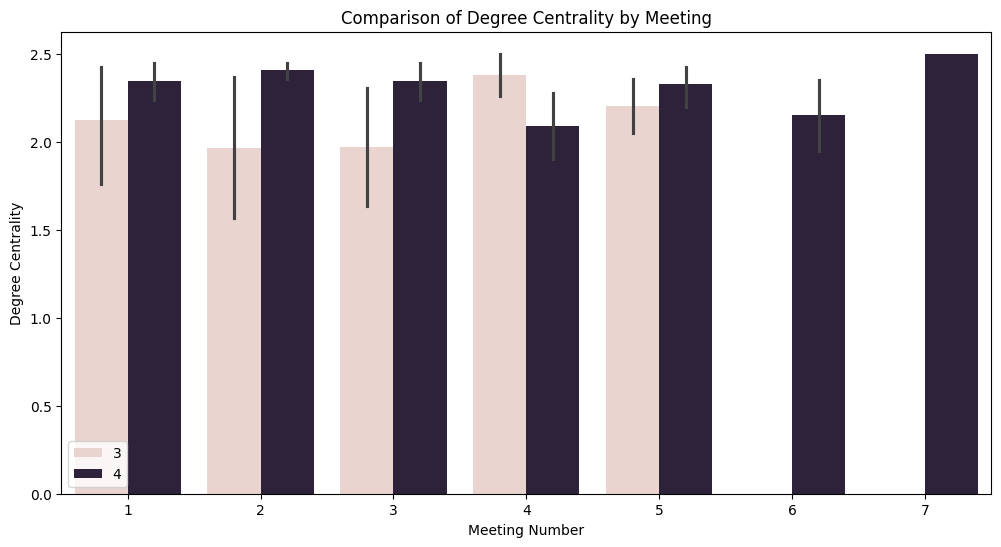

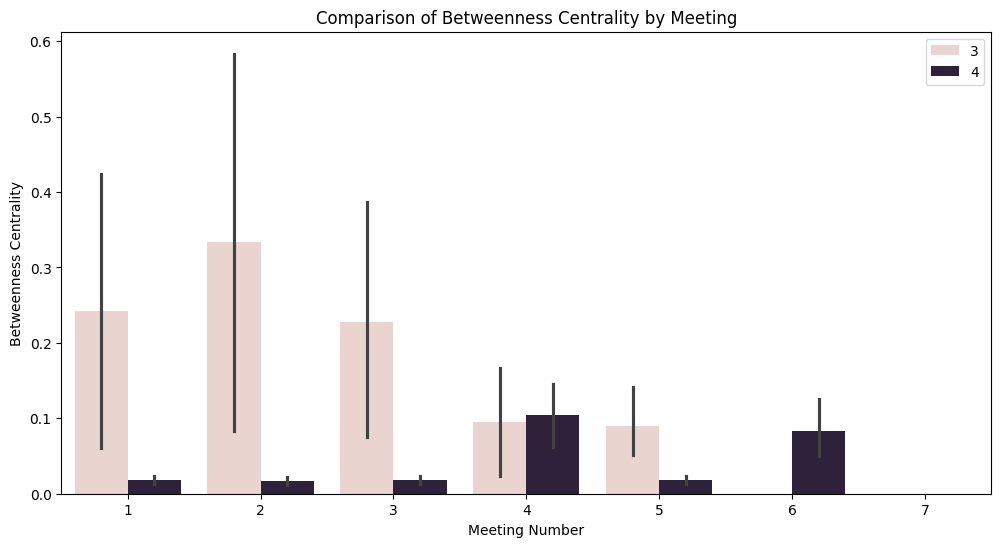

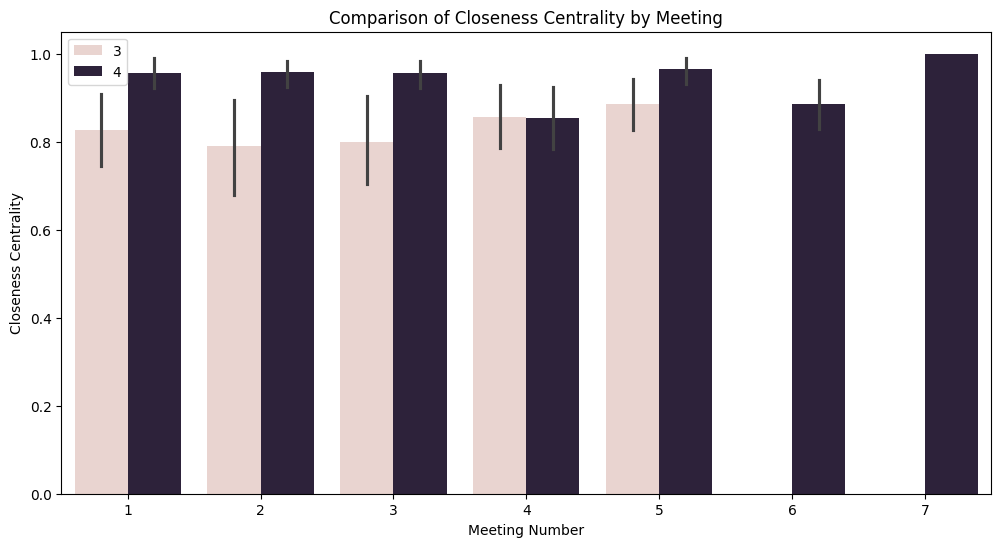

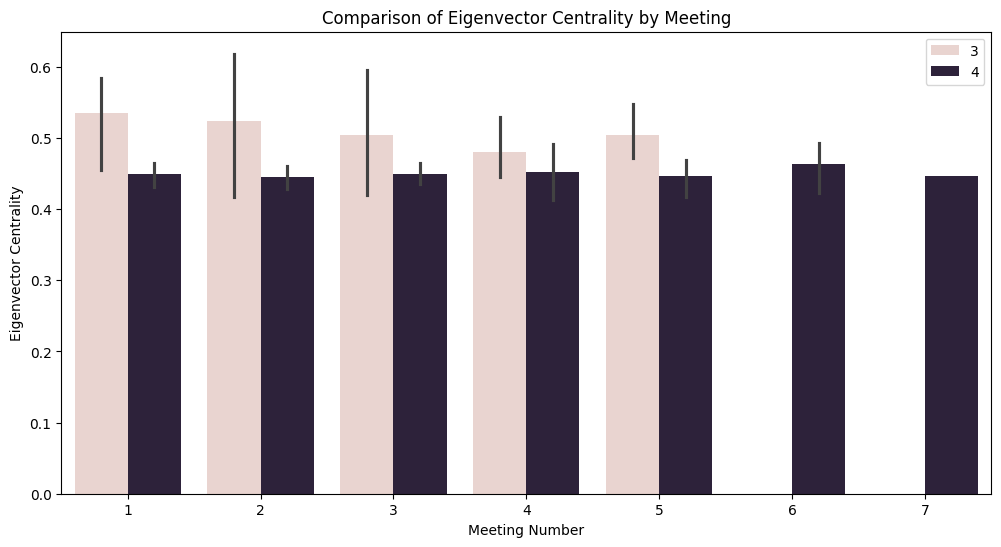

In [571]:
# Plot comparison of densities
plt.figure(figsize=(12, 6))
sns.lineplot(data=pd.DataFrame({'Meeting': range(1, len(densities_project3)+1), 'Density': densities_project3}), x='Meeting', y='Density', label='Density Project 3')
sns.lineplot(data=pd.DataFrame({'Meeting': range(1, len(densities_project4)+1), 'Density': densities_project4}), x='Meeting', y='Density', label='Density Project 4')
plt.title('Comparison of Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot comparison of centralities
centrality_measures = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
for measure in centrality_measures:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=combined_dataset, x='meeting_number', y=measure, hue='project')
    plt.title(f'Comparison of {measure.replace("_", " ").title()} by Meeting')
    plt.xlabel('Meeting Number')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend()
    plt.show()

## Plot Interaction Network Graph

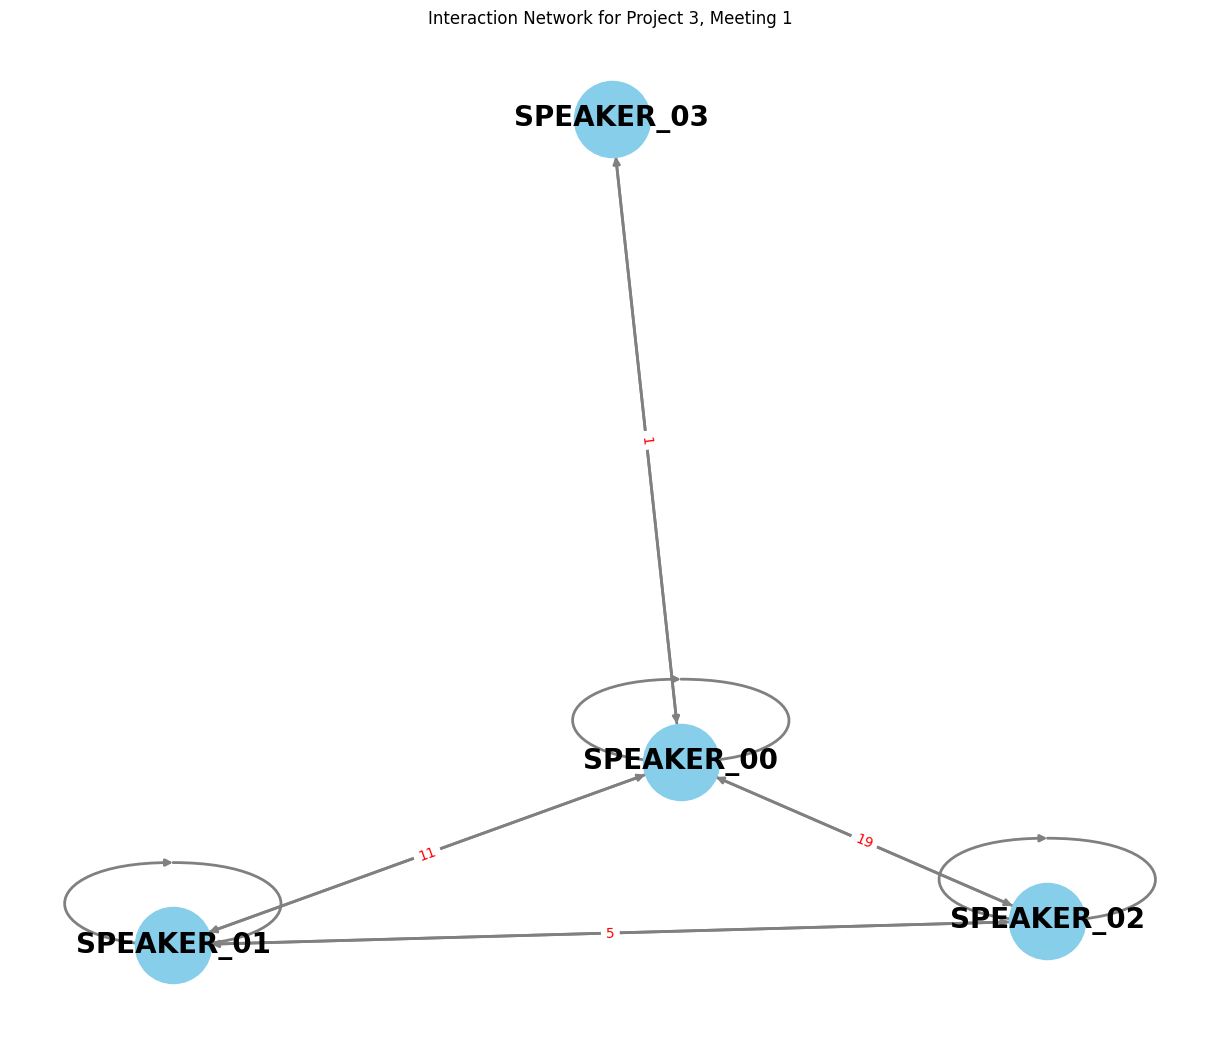

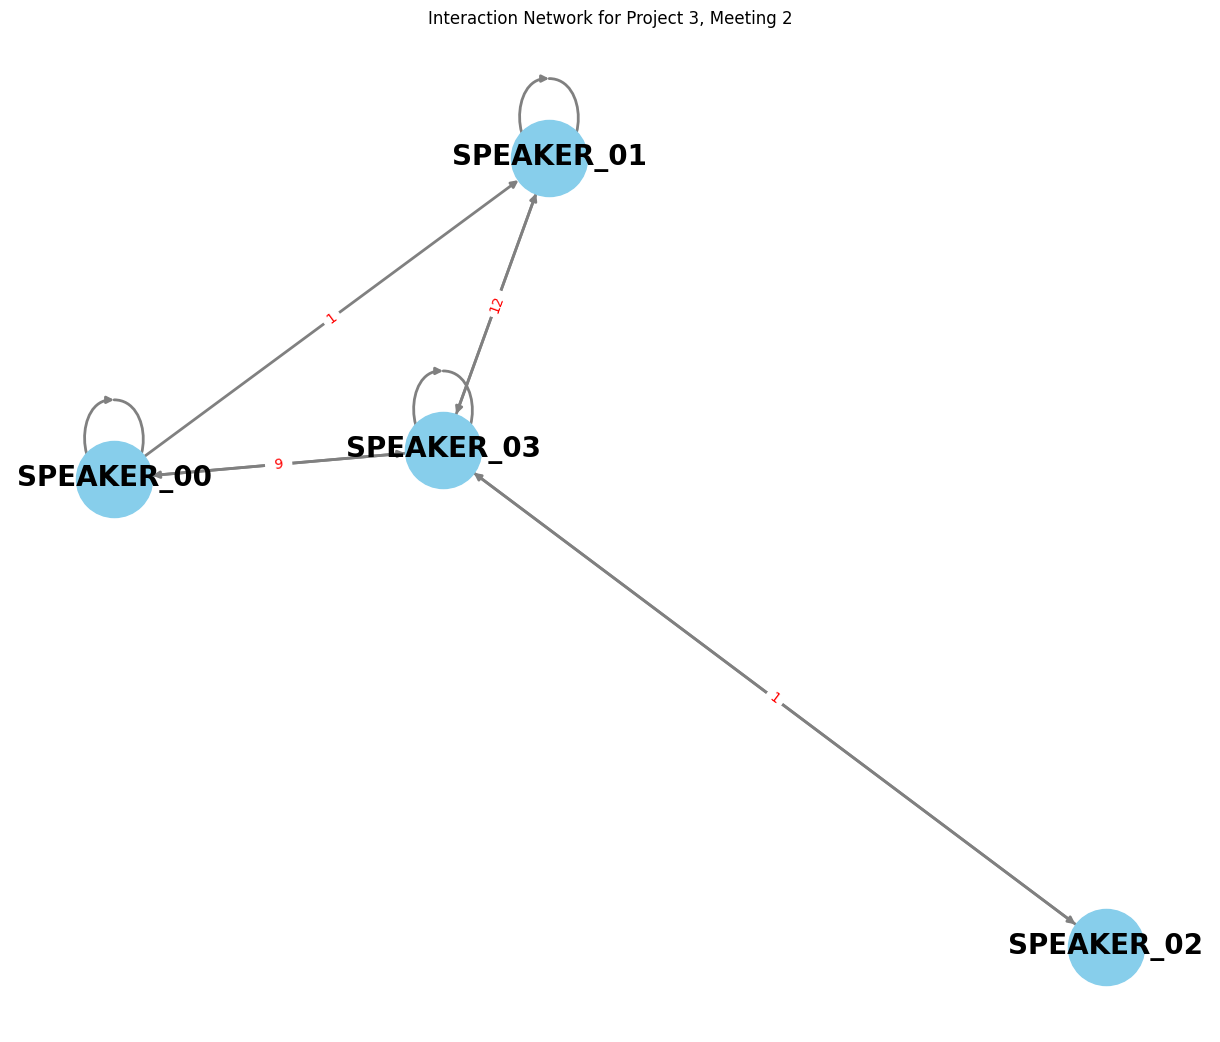

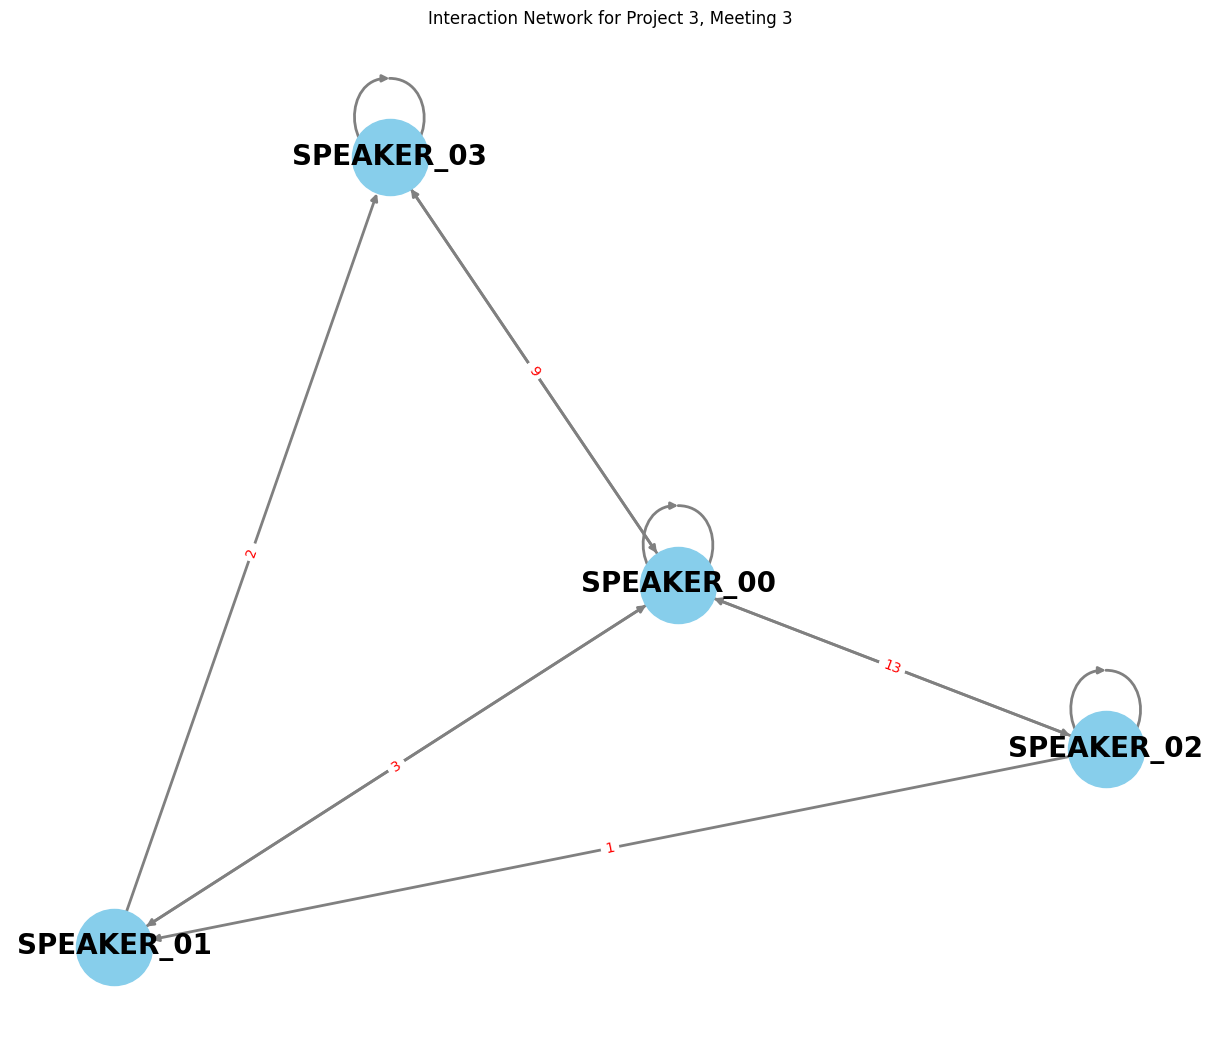

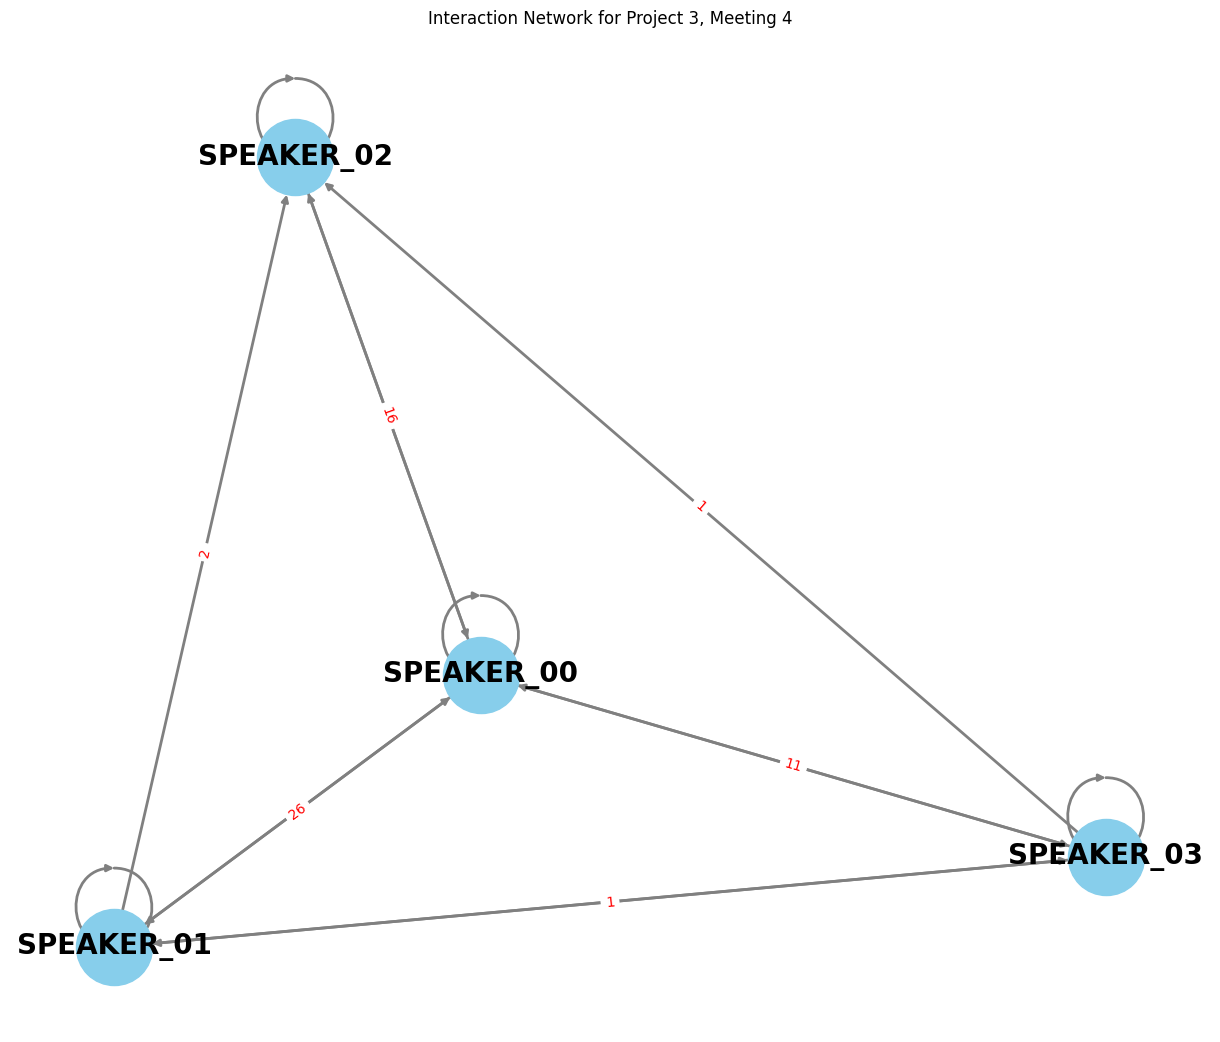

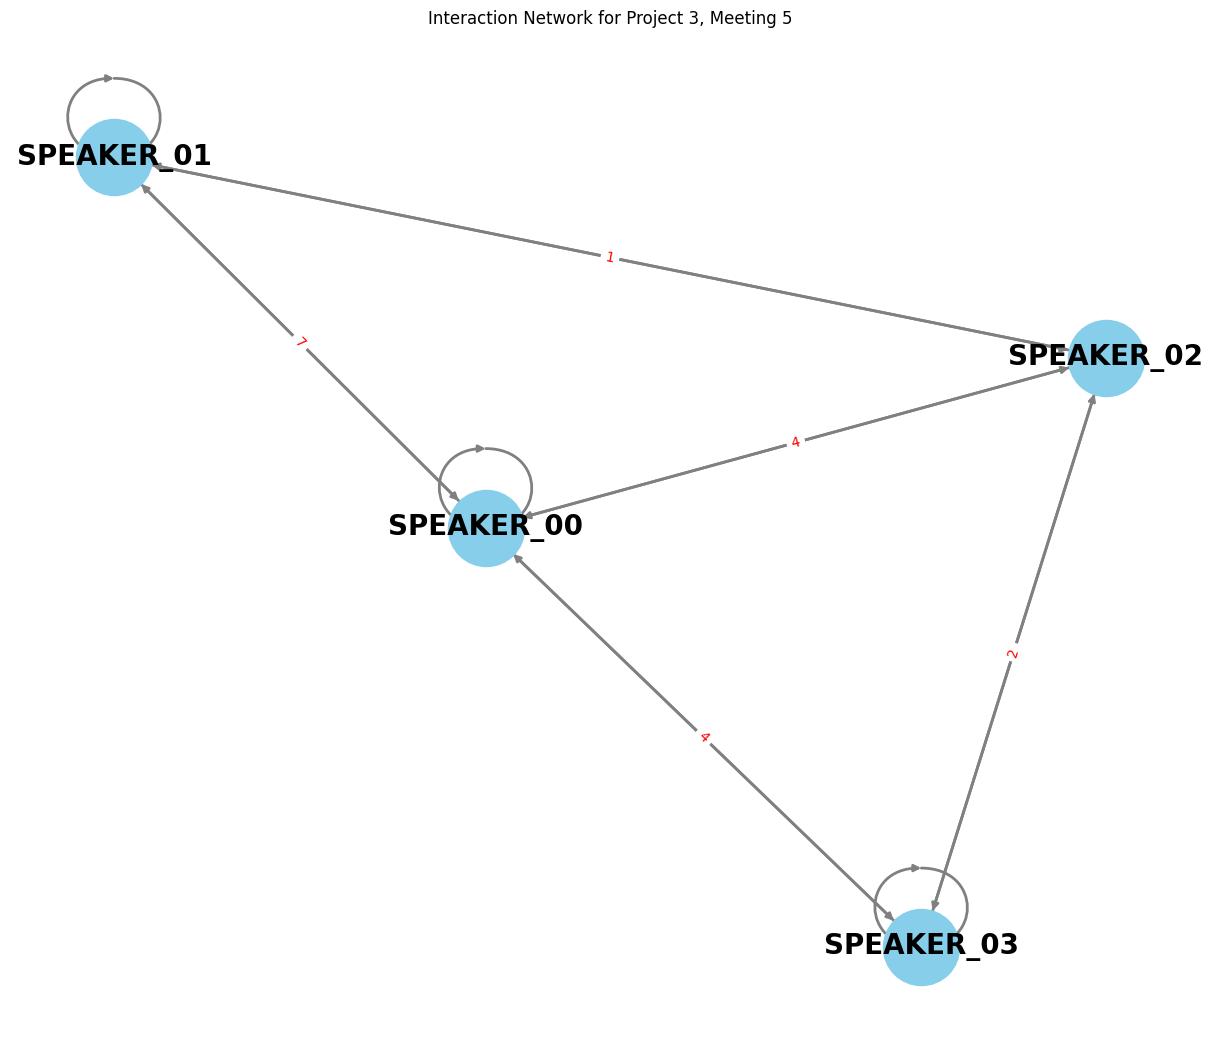

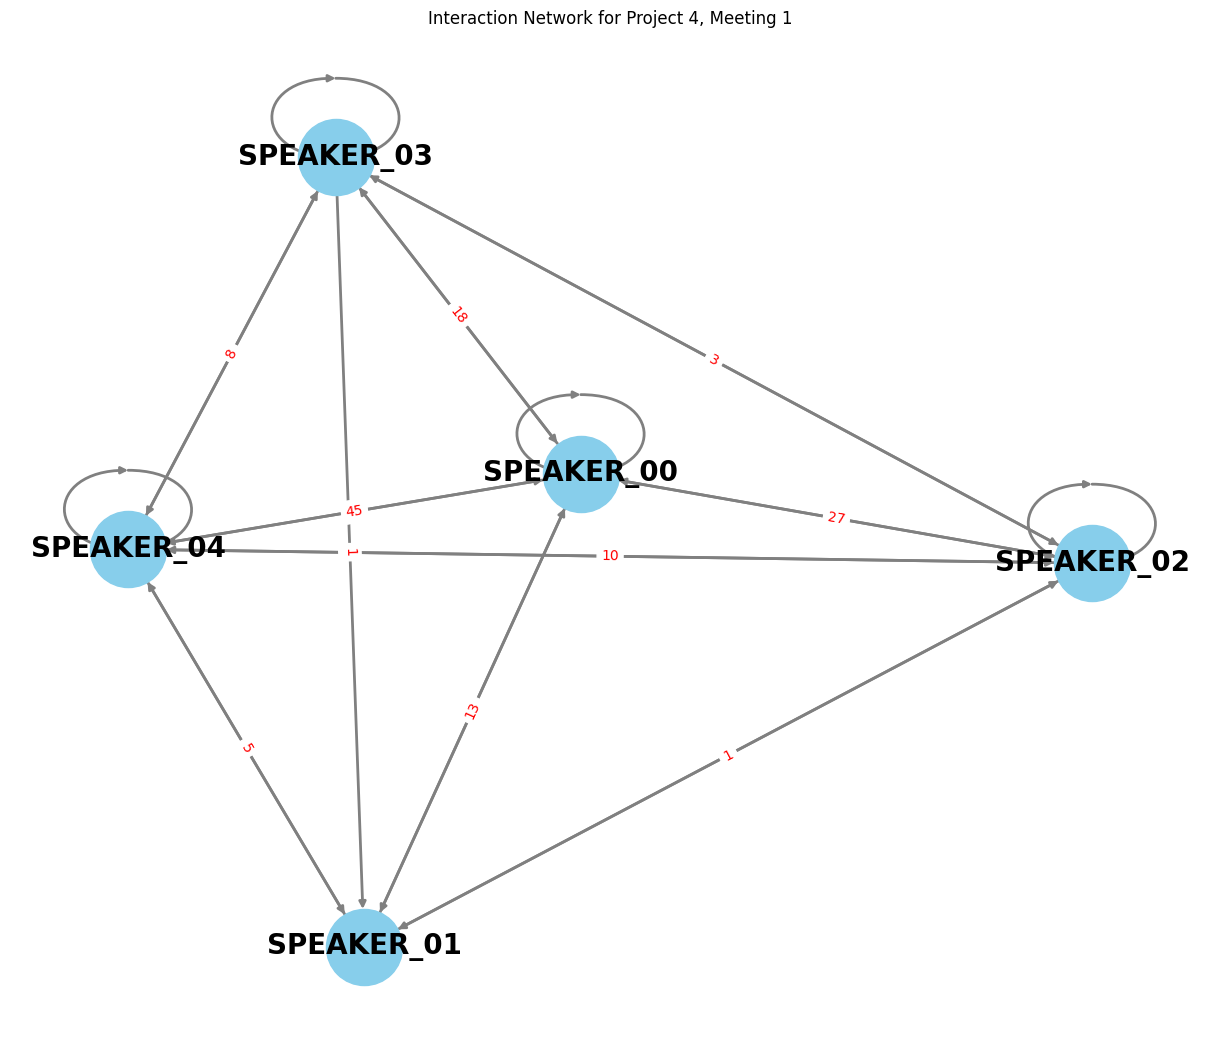

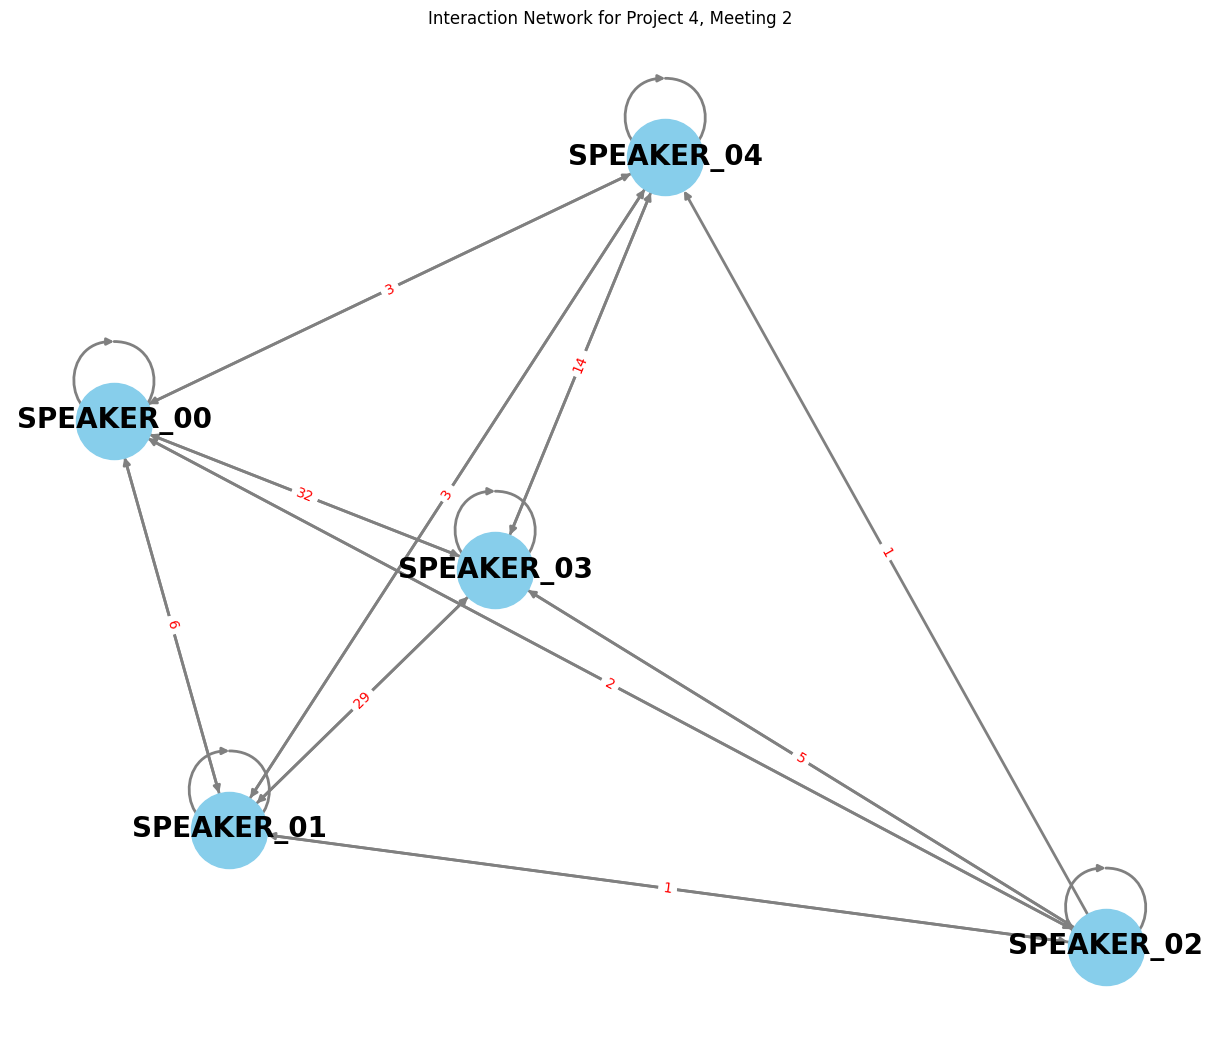

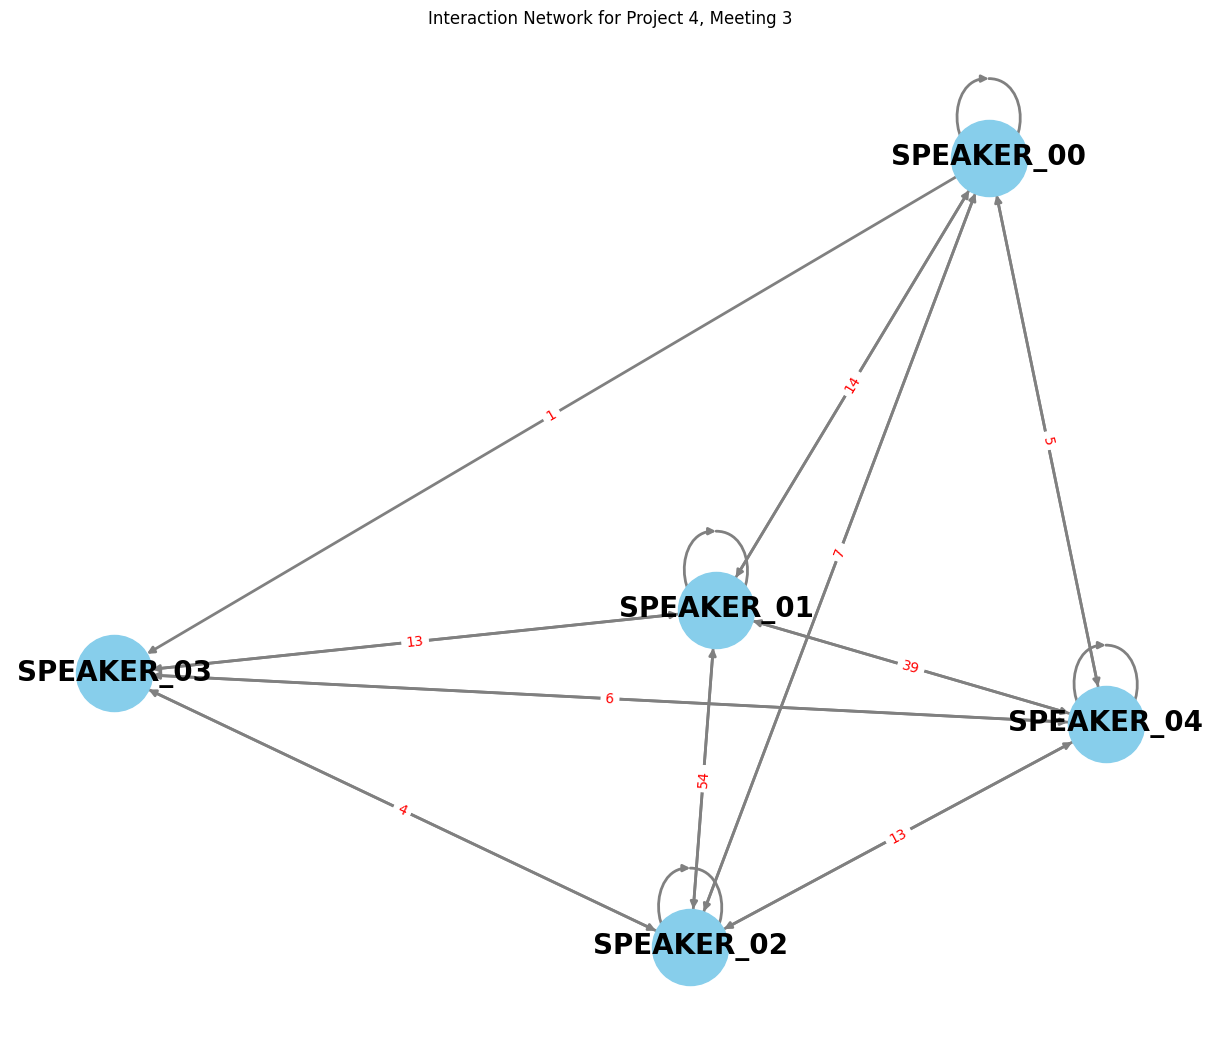

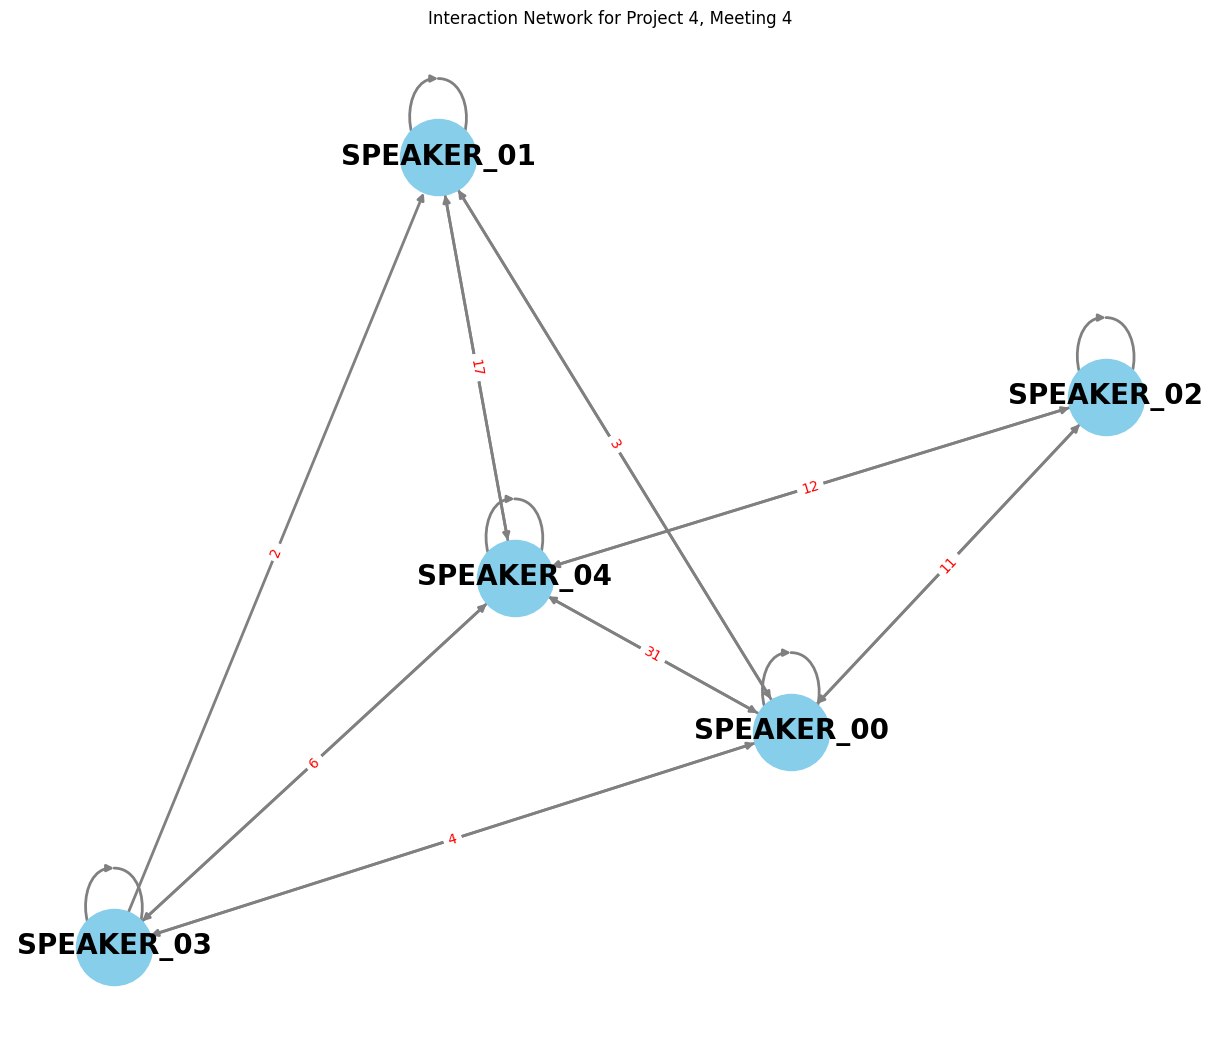

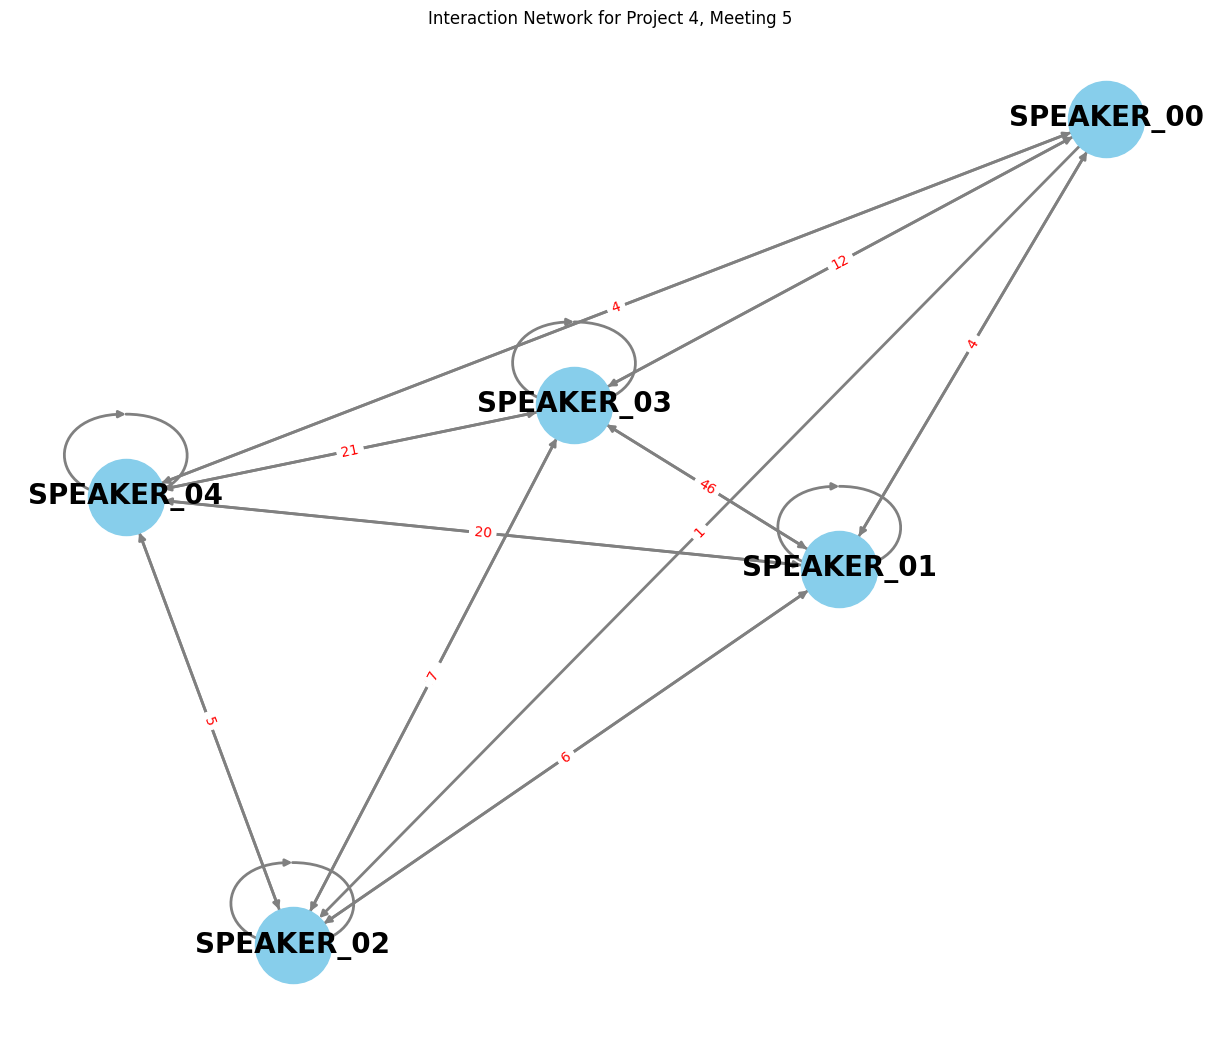

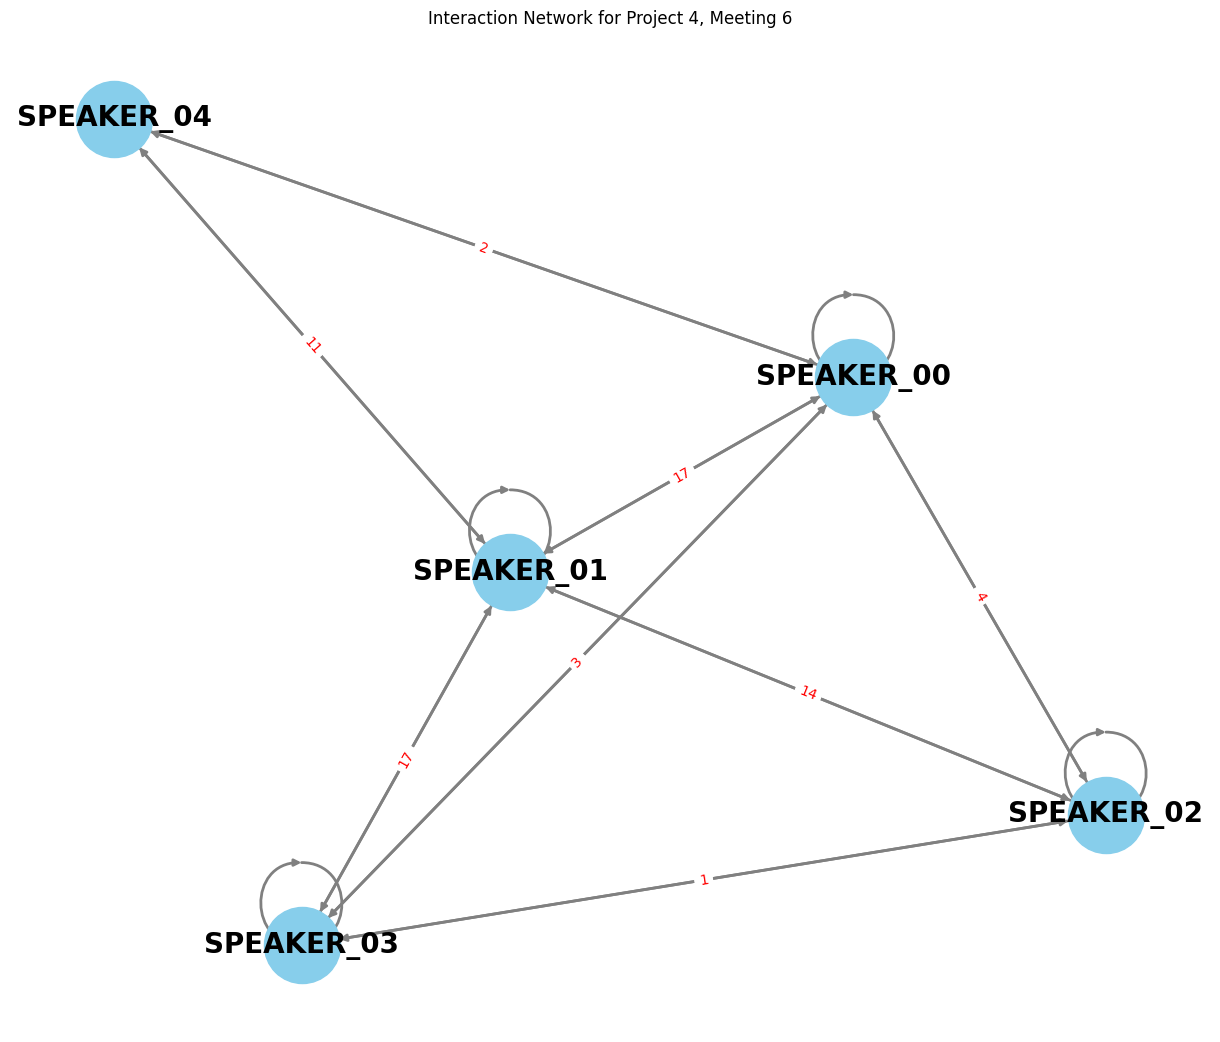

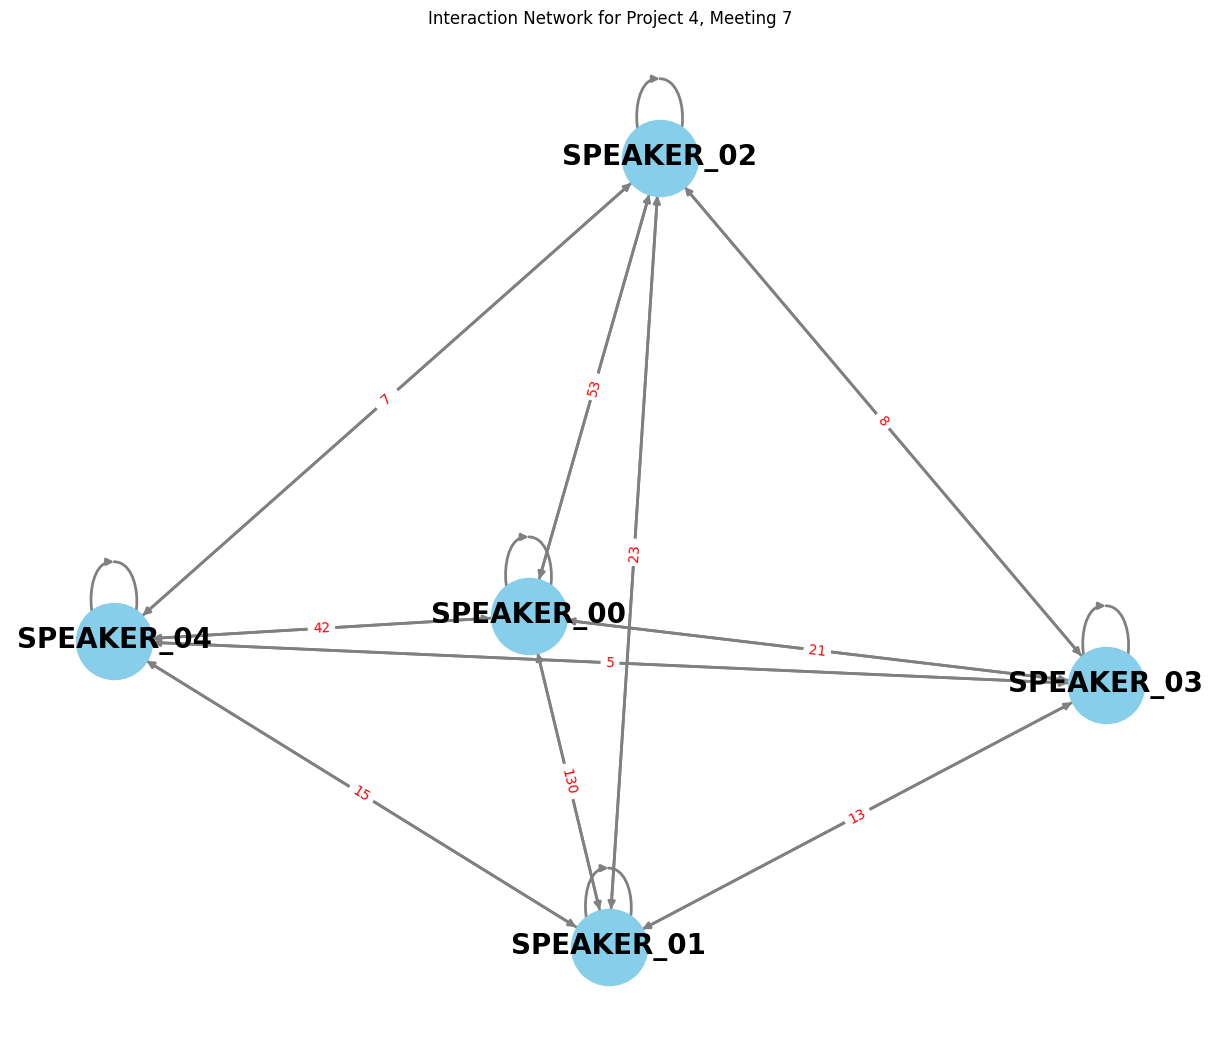

In [572]:
# Plotting Interaction Network Graph
def plot_interaction_network(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=20, font_color="black", font_weight="bold", width=2, edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

for i, G in enumerate(graphs_project3):
    plot_interaction_network(G, f'Interaction Network for Project 3, Meeting {i+1}')
for i, G in enumerate(graphs_project4):
    plot_interaction_network(G, f'Interaction Network for Project 4, Meeting {i+1}')